In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df_admit = pd.read_csv('admits_patients_diag.csv')

df_admit.admittime = pd.to_datetime(df_admit.admittime)
df_admit.dischtime = pd.to_datetime(df_admit.dischtime)
df_admit.deathtime = pd.to_datetime(df_admit.deathtime)

df_admit.head()

,Unnamed: 0,subject_id,hadm_id,admittime,dischtime,deathtime,admission_type,insurance,died_at_the_hospital,gender,...,injury,mental,misc,muscular,neoplasms,nervous,pregnancy,prenatal,respiratory,skin
0,0,10000032,22595853,2180-05-06 22:23:00,2180-05-07 17:15:00,NaT,EMERGENCY,Other,0,F,...,1,2,1,0,0,0,0,0,1,0
1,1,10000032,22841357,2180-06-26 18:27:00,2180-06-27 18:49:00,NaT,EMERGENCY,Medicaid,0,F,...,1,1,1,0,0,0,0,0,1,0
2,2,10000032,25742920,2180-08-05 23:44:00,2180-08-07 17:50:00,NaT,EMERGENCY,Medicaid,0,F,...,2,1,2,0,0,0,0,0,1,0
3,3,10000032,29079034,2180-07-23 12:35:00,2180-07-25 17:55:00,NaT,EMERGENCY,Medicaid,0,F,...,3,2,2,0,0,0,0,0,1,0
4,4,10000068,25022803,2160-03-03 23:16:00,2160-03-04 06:26:00,NaT,OBSERVATION,Other,0,F,...,0,1,0,0,0,0,0,0,0,0


In [3]:
df_admit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 276803 entries, 0 to 276802
Data columns (total 29 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   Unnamed: 0            276803 non-null  int64         
 1   subject_id            276803 non-null  int64         
 2   hadm_id               276803 non-null  int64         
 3   admittime             276803 non-null  datetime64[ns]
 4   dischtime             276803 non-null  datetime64[ns]
 5   deathtime             5216 non-null    datetime64[ns]
 6   admission_type        276803 non-null  object        
 7   insurance             276803 non-null  object        
 8   died_at_the_hospital  276803 non-null  int64         
 9   gender                276803 non-null  object        
 10  anchor_age            276803 non-null  int64         
 11  dod                   75425 non-null   object        
 12  blood                 276803 non-null  int64         
 13 

In [5]:
#LOS attribute converting timedelta type into float 'days'
df_admit['los'] = (df_admit['dischtime'] - df_admit['admittime']).dt.total_seconds()/86400
#verification
df_admit[['admittime', 'dischtime', 'los']].head()

,admittime,dischtime,los
0,2180-05-06 22:23:00,2180-05-07 17:15:00,0.786111
1,2180-06-26 18:27:00,2180-06-27 18:49:00,1.015278
2,2180-08-05 23:44:00,2180-08-07 17:50:00,1.754167
3,2180-07-23 12:35:00,2180-07-25 17:55:00,2.222222
4,2160-03-03 23:16:00,2160-03-04 06:26:00,0.298611


In [6]:
#remove LOS with less than 0, as it means they could've died before admission

df_admit = df_admit[df_admit['los'] > 0]

df_admit.info()

<class 'pandas.core.frame.DataFrame'>
Index: 276703 entries, 0 to 276802
Data columns (total 30 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   Unnamed: 0            276703 non-null  int64         
 1   subject_id            276703 non-null  int64         
 2   hadm_id               276703 non-null  int64         
 3   admittime             276703 non-null  datetime64[ns]
 4   dischtime             276703 non-null  datetime64[ns]
 5   deathtime             5166 non-null    datetime64[ns]
 6   admission_type        276703 non-null  object        
 7   insurance             276703 non-null  object        
 8   died_at_the_hospital  276703 non-null  int64         
 9   gender                276703 non-null  object        
 10  anchor_age            276703 non-null  int64         
 11  dod                   75368 non-null   object        
 12  blood                 276703 non-null  int64         
 13  circ

In [7]:
df_admit.died_at_the_hospital.value_counts()

died_at_the_hospital
0    271537
1      5166
Name: count, dtype: int64

In [8]:
#convert extremes of age into range: newborn, young adult, middle adult, and senior
age_ranges = [(0, 13), (14, 36), (37, 56), (57, 100)]
for num, cat_range in enumerate(age_ranges):
    df_admit['anchor_age'] = np.where(df_admit['anchor_age'].between(cat_range[0],cat_range[1]), num, df_admit['anchor_age'])

age_dict = {0: 'NEWBORN', 1: 'YOUNG_ADULT', 2: 'MIDDLE_ADULT', 3: 'SENIOR'}
df_admit['anchor_age'] = df_admit['anchor_age'].replace(age_dict)
df_admit.anchor_age.value_counts()

anchor_age
SENIOR          145256
MIDDLE_ADULT     81886
YOUNG_ADULT      49561
Name: count, dtype: int64

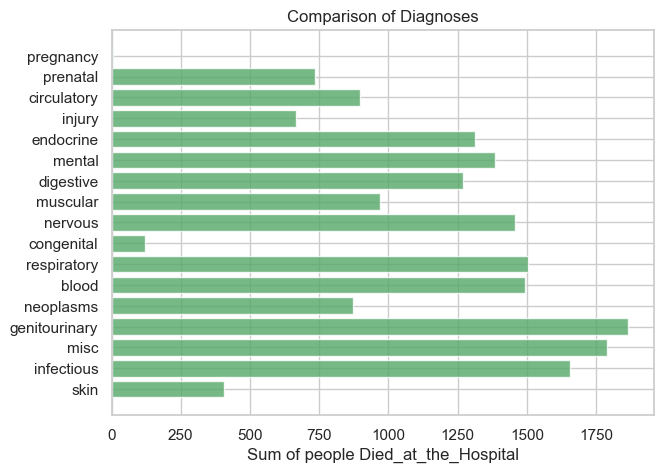

In [9]:
import seaborn as sns

# Look at the median LOS by diagnosis category
diag_cat_list = ['skin', 'infectious',  'misc', 'genitourinary', 'neoplasms', 'blood', 'respiratory', 
                  'congenital','nervous', 'muscular', 'digestive', 'mental', 'endocrine', 'injury',
                 'circulatory', 'prenatal',  'pregnancy']

results = []
for variable in diag_cat_list:
    results.append(df_admit[[variable, 'died_at_the_hospital']].groupby(variable).sum().reset_index().values[1][1])


sns.set(style="whitegrid")
fig, ax = plt.subplots(figsize=(7,5))
ind = range(len(results))
ax.barh(ind, results, color = '#55a868', alpha=0.8)
ax.set_yticks(ind)
ax.set_yticklabels(diag_cat_list)
ax.set_xlabel('Sum of people Died_at_the_Hospital')
ax.tick_params(left=False, right=False, top=False) 
ax.set_title('Comparison of Diagnoses'.format(variable))
plt.show()

In [11]:
#ICU stays data extraction

mimic_path = '/Users/andylim/Downloads/mimic-iv-2.2/'

def read_icustays_table(mimic_path):
    icustays = pd.read_csv(mimic_path + 'icu/icustays.csv.gz')
    return icustays

icustays = read_icustays_table(mimic_path)
icustays.head()

,subject_id,hadm_id,stay_id,first_careunit,last_careunit,intime,outtime,los
0,10000032,29079034,39553978,Medical Intensive Care Unit (MICU),Medical Intensive Care Unit (MICU),2180-07-23 14:00:00,2180-07-23 23:50:47,0.410266
1,10000980,26913865,39765666,Medical Intensive Care Unit (MICU),Medical Intensive Care Unit (MICU),2189-06-27 08:42:00,2189-06-27 20:38:27,0.497535
2,10001217,24597018,37067082,Surgical Intensive Care Unit (SICU),Surgical Intensive Care Unit (SICU),2157-11-20 19:18:02,2157-11-21 22:08:00,1.118032
3,10001217,27703517,34592300,Surgical Intensive Care Unit (SICU),Surgical Intensive Care Unit (SICU),2157-12-19 15:42:24,2157-12-20 14:27:41,0.948113
4,10001725,25563031,31205490,Medical/Surgical Intensive Care Unit (MICU/SICU),Medical/Surgical Intensive Care Unit (MICU/SICU),2110-04-11 15:52:22,2110-04-12 23:59:56,1.338588


In [12]:
icustays['category'] = icustays['first_careunit']
icu_list = icustays.groupby('hadm_id')['category'].apply(list).reset_index()
icu_list.head()

,hadm_id,category
0,20000094,[Coronary Care Unit (CCU)]
1,20000147,[Coronary Care Unit (CCU)]
2,20000351,[Medical/Surgical Intensive Care Unit (MICU/SI...
3,20000808,"[Surgical Intensive Care Unit (SICU), Surgical..."
4,20001305,[Medical/Surgical Intensive Care Unit (MICU/SI...


In [13]:
icustays['first_careunit'].value_counts()

first_careunit
Medical Intensive Care Unit (MICU)                  15898
Medical/Surgical Intensive Care Unit (MICU/SICU)    12733
Cardiac Vascular Intensive Care Unit (CVICU)        11582
Surgical Intensive Care Unit (SICU)                 11161
Trauma SICU (TSICU)                                  8692
Coronary Care Unit (CCU)                             8311
Neuro Intermediate                                   2035
Neuro Surgical Intensive Care Unit (Neuro SICU)      1762
Neuro Stepdown                                       1007
Name: count, dtype: int64

In [15]:
# Create admission-ICU matrix
icu_item = pd.get_dummies(icu_list['category'].apply(pd.Series).stack()).groupby(level=0).sum()
icu_item[icu_item >= 1] = 1
icu_item = icu_item.join(icu_list['hadm_id'], how="outer")
icu_item.head()

,Cardiac Vascular Intensive Care Unit (CVICU),Coronary Care Unit (CCU),Medical Intensive Care Unit (MICU),Medical/Surgical Intensive Care Unit (MICU/SICU),Neuro Intermediate,Neuro Stepdown,Neuro Surgical Intensive Care Unit (Neuro SICU),Surgical Intensive Care Unit (SICU),Trauma SICU (TSICU),hadm_id
0,0,1,0,0,0,0,0,0,0,20000094
1,0,1,0,0,0,0,0,0,0,20000147
2,0,0,0,1,0,0,0,0,0,20000351
3,0,0,0,0,0,0,0,1,0,20000808
4,0,0,0,1,0,0,0,0,0,20001305


In [16]:
# Merge ICU data with main dataFrame
final_df = df_admit.merge(icu_item, how='outer', on='hadm_id')
final_df.head()

,Unnamed: 0,subject_id,hadm_id,admittime,dischtime,deathtime,admission_type,insurance,died_at_the_hospital,gender,...,los,Cardiac Vascular Intensive Care Unit (CVICU),Coronary Care Unit (CCU),Medical Intensive Care Unit (MICU),Medical/Surgical Intensive Care Unit (MICU/SICU),Neuro Intermediate,Neuro Stepdown,Neuro Surgical Intensive Care Unit (Neuro SICU),Surgical Intensive Care Unit (SICU),Trauma SICU (TSICU)
0,0.0,10000032.0,22595853,2180-05-06 22:23:00,2180-05-07 17:15:00,NaT,EMERGENCY,Other,0.0,F,...,0.786111,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.0,10000032.0,22841357,2180-06-26 18:27:00,2180-06-27 18:49:00,NaT,EMERGENCY,Medicaid,0.0,F,...,1.015278,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2.0,10000032.0,25742920,2180-08-05 23:44:00,2180-08-07 17:50:00,NaT,EMERGENCY,Medicaid,0.0,F,...,1.754167,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3.0,10000032.0,29079034,2180-07-23 12:35:00,2180-07-25 17:55:00,NaT,EMERGENCY,Medicaid,0.0,F,...,2.222222,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4.0,10000068.0,25022803,2160-03-03 23:16:00,2160-03-04 06:26:00,NaT,OBSERVATION,Other,0.0,F,...,0.298611,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [17]:
# Replace NaNs with 0
final_df['Cardiac Vascular Intensive Care Unit (CVICU)'].fillna(value=0, inplace=True)
final_df['Coronary Care Unit (CCU)'].fillna(value=0, inplace=True)
final_df['Medical Intensive Care Unit (MICU)'].fillna(value=0, inplace=True)
final_df['Medical/Surgical Intensive Care Unit (MICU/SICU)'].fillna(value=0, inplace=True)
final_df['Neuro Intermediate'].fillna(value=0, inplace=True)
final_df['Neuro Stepdown'].fillna(value=0, inplace=True)
final_df['Neuro Surgical Intensive Care Unit (Neuro SICU)'].fillna(value=0, inplace=True)
final_df['Surgical Intensive Care Unit (SICU)'].fillna(value=0, inplace=True)
final_df['Trauma SICU (TSICU)'].fillna(value=0, inplace=True)


In [19]:
final_df

,Unnamed: 0,subject_id,hadm_id,admittime,dischtime,deathtime,admission_type,insurance,died_at_the_hospital,gender,...,los,Cardiac Vascular Intensive Care Unit (CVICU),Coronary Care Unit (CCU),Medical Intensive Care Unit (MICU),Medical/Surgical Intensive Care Unit (MICU/SICU),Neuro Intermediate,Neuro Stepdown,Neuro Surgical Intensive Care Unit (Neuro SICU),Surgical Intensive Care Unit (SICU),Trauma SICU (TSICU)
0,0.0,10000032.0,22595853,2180-05-06 22:23:00,2180-05-07 17:15:00,NaT,EMERGENCY,Other,0.0,F,...,0.786111,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,10000032.0,22841357,2180-06-26 18:27:00,2180-06-27 18:49:00,NaT,EMERGENCY,Medicaid,0.0,F,...,1.015278,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2.0,10000032.0,25742920,2180-08-05 23:44:00,2180-08-07 17:50:00,NaT,EMERGENCY,Medicaid,0.0,F,...,1.754167,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3.0,10000032.0,29079034,2180-07-23 12:35:00,2180-07-25 17:55:00,NaT,EMERGENCY,Medicaid,0.0,F,...,2.222222,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4.0,10000068.0,25022803,2160-03-03 23:16:00,2160-03-04 06:26:00,NaT,OBSERVATION,Other,0.0,F,...,0.298611,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
303516,NaN,NaN,29998113,NaT,NaT,NaT,NaN,NaN,NaN,NaN,...,NaN,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
303517,NaN,NaN,29998399,NaT,NaT,NaT,NaN,NaN,NaN,NaN,...,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
303518,NaN,NaN,29998702,NaT,NaT,NaT,NaN,NaN,NaN,NaN,...,NaN,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
303519,NaN,NaN,29998928,NaT,NaT,NaT,NaN,NaN,NaN,NaN,...,NaN,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [20]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303521 entries, 0 to 303520
Data columns (total 39 columns):
 #   Column                                            Non-Null Count   Dtype         
---  ------                                            --------------   -----         
 0   Unnamed: 0                                        276703 non-null  float64       
 1   subject_id                                        276703 non-null  float64       
 2   hadm_id                                           303521 non-null  int64         
 3   admittime                                         276703 non-null  datetime64[ns]
 4   dischtime                                         276703 non-null  datetime64[ns]
 5   deathtime                                         5166 non-null    datetime64[ns]
 6   admission_type                                    276703 non-null  object        
 7   insurance                                         276703 non-null  object        
 8   died_at_the_ho

In [21]:
# Drop unused or no longer needed columns
final_df.drop(columns=['Unnamed: 0', 'subject_id', 'hadm_id', 'admittime', 'dischtime', 'deathtime','dod', 'los'], inplace=True)

final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303521 entries, 0 to 303520
Data columns (total 31 columns):
 #   Column                                            Non-Null Count   Dtype  
---  ------                                            --------------   -----  
 0   admission_type                                    276703 non-null  object 
 1   insurance                                         276703 non-null  object 
 2   died_at_the_hospital                              276703 non-null  float64
 3   gender                                            276703 non-null  object 
 4   anchor_age                                        276703 non-null  object 
 5   blood                                             276703 non-null  float64
 6   circulatory                                       276703 non-null  float64
 7   congenital                                        276703 non-null  float64
 8   digestive                                         276703 non-null  float64
 9   endo

In [25]:
# Create dummy columns for categorical variables
prefix_cols = ['ADM', 'INS', 'AGE']
dummy_cols = ['admission_type', 'insurance', 'anchor_age']
df_cleaned = pd.get_dummies(final_df, prefix=prefix_cols, columns=dummy_cols)
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303521 entries, 0 to 303520
Data columns (total 38 columns):
 #   Column                                            Non-Null Count   Dtype  
---  ------                                            --------------   -----  
 0   died_at_the_hospital                              276703 non-null  float64
 1   gender                                            276703 non-null  object 
 2   blood                                             276703 non-null  float64
 3   circulatory                                       276703 non-null  float64
 4   congenital                                        276703 non-null  float64
 5   digestive                                         276703 non-null  float64
 6   endocrine                                         276703 non-null  float64
 7   genitourinary                                     276703 non-null  float64
 8   infectious                                        276703 non-null  float64
 9   inju

In [26]:
# Drop rows that contain NaN values
df_cleaned.dropna(axis=0, inplace=True)
# Check for any remaining NaNs
df_cleaned.isnull().values.sum()

0

In [27]:
df_cleaned.isnull().sum()

died_at_the_hospital                                0
gender                                              0
blood                                               0
circulatory                                         0
congenital                                          0
digestive                                           0
endocrine                                           0
genitourinary                                       0
infectious                                          0
injury                                              0
mental                                              0
misc                                                0
muscular                                            0
neoplasms                                           0
nervous                                             0
pregnancy                                           0
prenatal                                            0
respiratory                                         0
skin                        

In [28]:
# Convert gender into numeric boolean attribute
df_cleaned['gender'].replace({'M': 0, 'F':1}, inplace=True)
df_cleaned.head()


,died_at_the_hospital,gender,blood,circulatory,congenital,digestive,endocrine,genitourinary,infectious,injury,...,ADM_ELECTIVE,ADM_EMERGENCY,ADM_OBSERVATION,ADM_SURGICAL SAME DAY ADMISSION,INS_Medicaid,INS_Medicare,INS_Other,AGE_MIDDLE_ADULT,AGE_SENIOR,AGE_YOUNG_ADULT
0,0.0,1,0.0,0.0,0.0,2.0,0.0,0.0,1.0,1.0,...,False,True,False,False,False,False,True,True,False,False
1,0.0,1,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,...,False,True,False,False,True,False,False,True,False,False
2,0.0,1,0.0,0.0,0.0,1.0,2.0,0.0,1.0,2.0,...,False,True,False,False,True,False,False,True,False,False
3,0.0,1,0.0,1.0,0.0,1.0,2.0,0.0,1.0,3.0,...,False,True,False,False,True,False,False,True,False,False
4,0.0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,False,False,True,False,False,False,True,False,False,True


In [29]:
df_cleaned = df_cleaned.astype(int)

In [30]:
# Check for any remaining NaNs
df_cleaned.isnull().values.sum()

0

In [31]:
# Target Variable (died_at_the_hospital)
HOSP_MORT = df_cleaned['died_at_the_hospital'].values
# Prediction Features
features = df_cleaned.drop(columns=['died_at_the_hospital'])

In [45]:
df_cleaned.to_csv('ready_to_train.csv')

In [32]:
from sklearn.model_selection import train_test_split

# Split into training set 80% and test set 20%
X_train, X_test, y_train, y_test = train_test_split(features, 
                                                    HOSP_MORT, 
                                                    test_size = .20, 
                                                    random_state = 0)

# Show the results of the split
print("Training set has {} samples.".format(X_train.shape[0]))
print("Testing set has {} samples.".format(X_test.shape[0]))

Training set has 221362 samples.
Testing set has 55341 samples.


In [33]:
from sklearn.metrics import r2_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

# Regression models used from scikit-learn for comparison
models = [GradientBoostingRegressor(random_state = 0), 
          LinearRegression(),
          KNeighborsRegressor(),
          RandomForestRegressor(random_state = 0)]

results = {}

for model in models:
    # Instantiate and fit Regressor Model
    reg_model = model
    reg_model.fit(X_train, y_train)
    
    # Make predictions with model
    y_test_preds = reg_model.predict(X_test)
    
    # Grab model name and store results associated with model
    name = str(model).split("(")[0]

    results[name] = r2_score(y_test, y_test_preds)
    print('{} done.'.format(name))



GradientBoostingRegressor done.
LinearRegression done.
KNeighborsRegressor done.
RandomForestRegressor done.


Text(0.5, 1.0, 'Comparison of Regression Models')

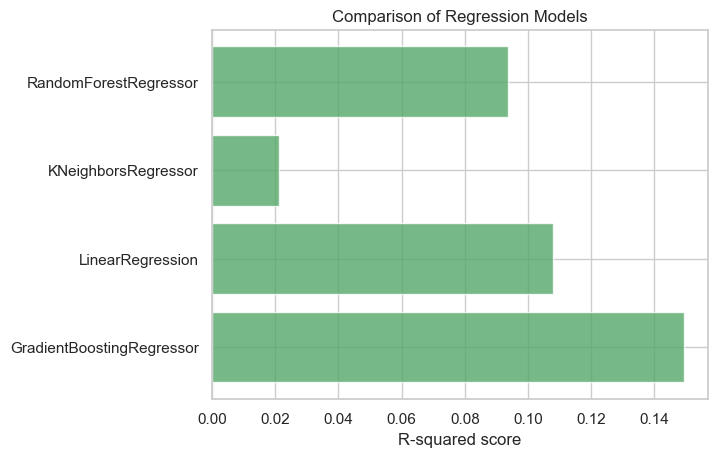

In [35]:
# R2 score results
fig, ax = plt.subplots()
ind = range(len(results))
ax.barh(ind, list(results.values()), align='center', 
        color = '#55a868', alpha=0.8)
ax.set_yticks(ind)
ax.set_yticklabels(results.keys())
ax.set_xlabel('R-squared score')
ax.tick_params(left=False, top=False, right=False) 
ax.set_title('Comparison of Regression Models')


In [36]:
reg_model = GradientBoostingRegressor(random_state=0)   
reg_model.fit(X_train, y_train)
y_test_preds = reg_model.predict(X_test)
r2_not_refined = r2_score(y_test, y_test_preds)
print("R2 score is: {:2f}".format(r2_not_refined))

R2 score is: 0.149489


In [41]:
from sklearn.model_selection import GridSearchCV

# Split into train 80% and test 20%
X_train, X_test, y_train, y_test = train_test_split(features, 
                                                    HOSP_MORT, 
                                                    test_size = .20, 
                                                    random_state = 42)
                                                    
# Set the parameters by cross-validation
#tuned_parameters = [{'n_estimators': [100, 200, 300],
#                     'max_depth' : [2, 3, 4],
#                     'loss': ['ls', 'lad', 'huber']}]
tuned_parameters = [{'n_estimators': [200, 300],
                     'max_depth' : [3, 4],
                     'loss': ['huber', 'quantile', 'absolute_error', 'squared_error']}]

# create and fit a ridge regression model, testing each alpha
reg_model = GradientBoostingRegressor()  
grid = GridSearchCV(reg_model, tuned_parameters, cv=3, verbose = 1, n_jobs = -1)
grid.fit(X_train, y_train)
reg_model_optimized = grid.best_estimator_

# summarize the results of the grid search
print(grid.best_score_)
print(grid.best_estimator_)

Fitting 3 folds for each of 16 candidates, totalling 48 fits
0.14811190358114498
GradientBoostingRegressor(max_depth=4, n_estimators=200)


In [42]:
y_test_preds = reg_model_optimized.predict(X_test)
r2_optimized = r2_score(y_test, y_test_preds)
print("Optimized R2 score is: {:2f}".format(r2_optimized))

Optimized R2 score is: 0.132812
